# Louvain Modularity Clustering

## Theory

## Load dependencies

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

from tqdm import tqdm_notebook as tqdm

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale

In [4]:
from msci.utils import utils
from msci.utils.plot import plot_path_jn, plot_histogram_jn, animate

In [5]:
from msci.cleaning.features import *

## Import data

The dataframe `mac_address_df` contains mac addresses and the features used to cluster the mac addresses into groups. The `signal_df` contains all the *raw* signals recorded by the wifi harvesters.

In [6]:
mac_address_df = utils.import_mac_addresses()

In [7]:
print('{} mac addresses with {} features'.format(mac_address_df.shape[0], mac_address_df.shape[1]))

18719 mac addresses with 22 features


In [8]:
# Version 1 is the raw signals
signal_df = utils.import_signals(version=1)

In [9]:
lm_weighted = pd.read_csv('../../data/lm_subset_unweighted.csv')

In [10]:
mac_address_df = pd.merge(mac_address_df, lm_weighted, on='mac_address')

## Investigation

### Data Preparation

The `FEATURE_LIST` is shown below. The clustering algorithm will use these to determine the similarity between mac addresses. The two main features include *length of stay* and *radius of gyration*. These are later shown to be very contrasting for the different clusters.

In [14]:
FEATURE_LIST = [
    'length_of_stay',
    'radius_of_gyration',
    'count_density_variance',
    'av_speed',
    'av_turning_angle',
    'av_path_length',
    'av_straightness',
    'turning_angle_density',
]

In [16]:
mac_address_clean_df = mac_address_df[mac_address_df.frequency > 0].dropna(subset=FEATURE_LIST)

## Distributions

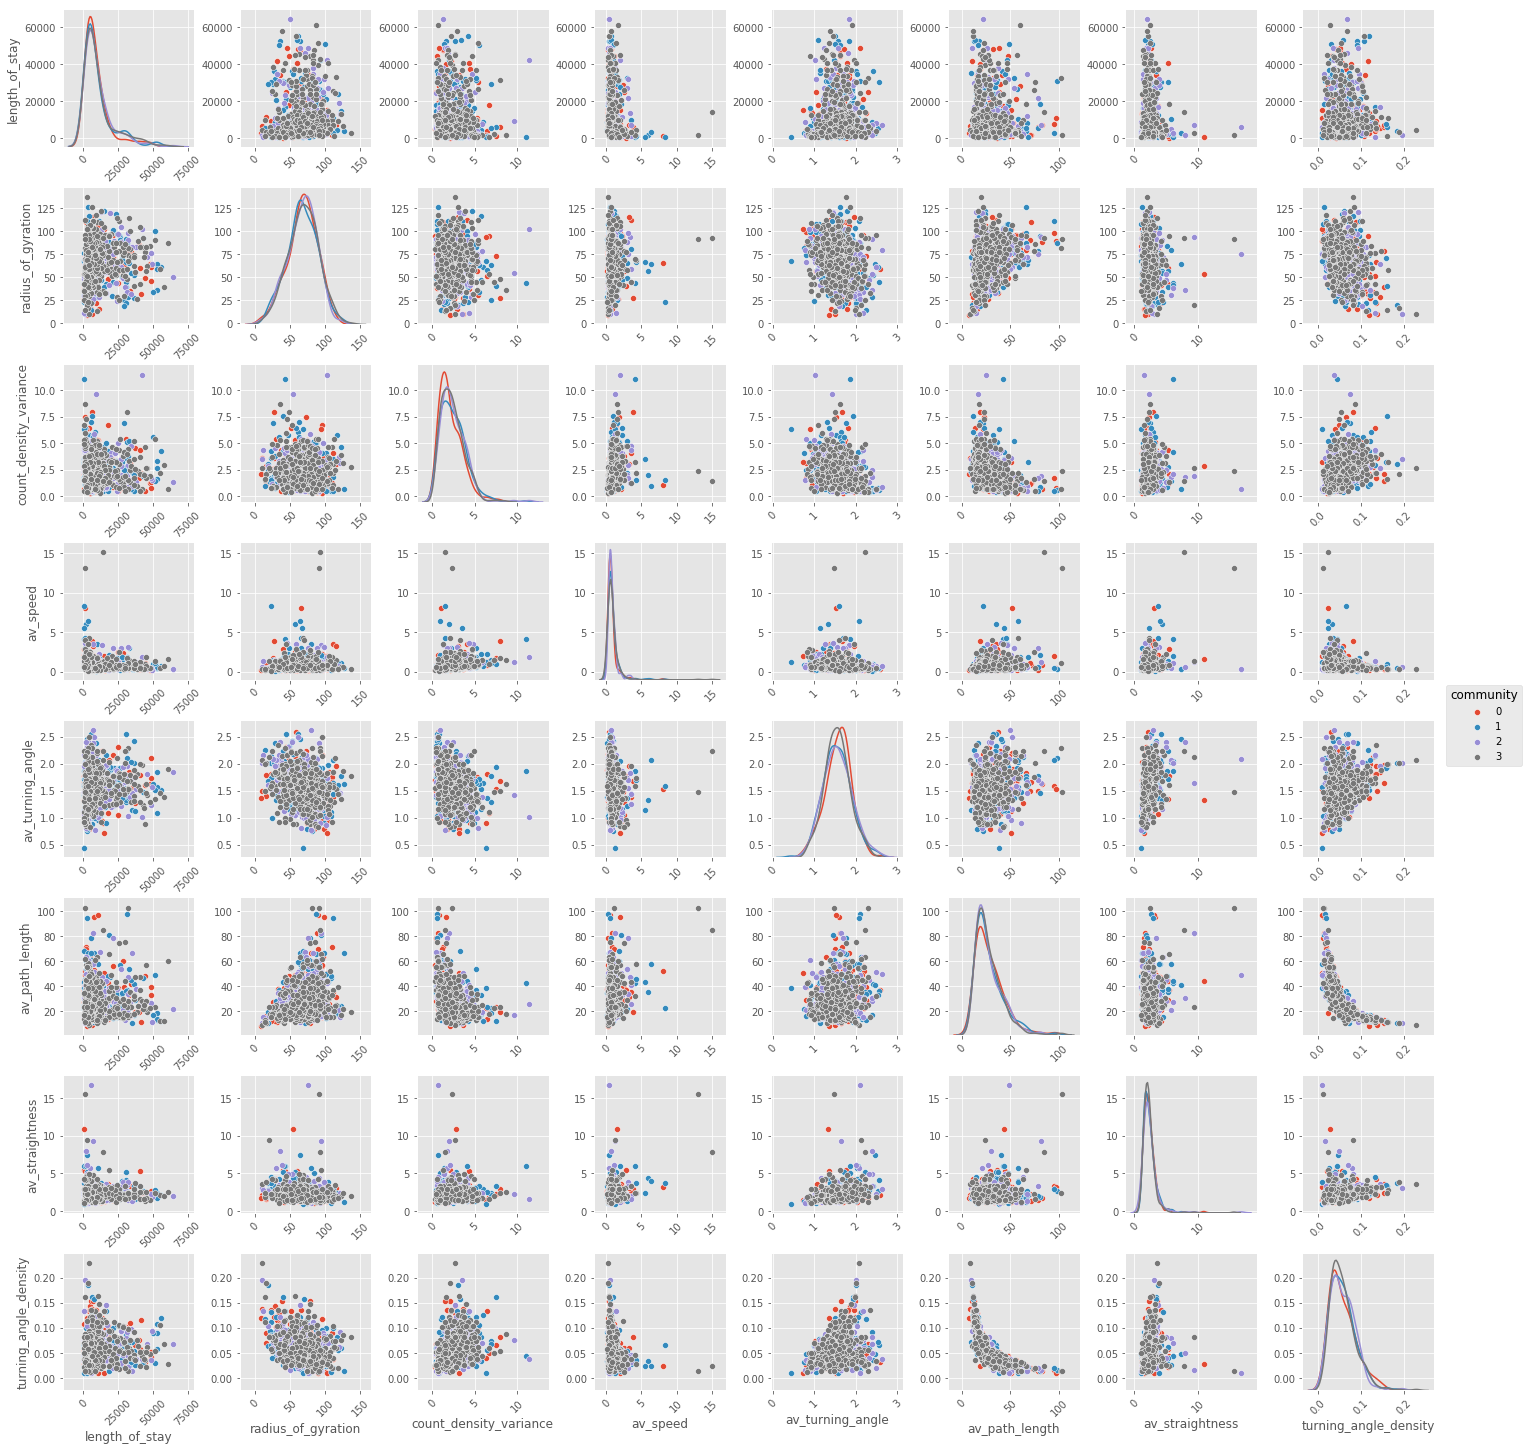

In [17]:
g = sns.pairplot(
    mac_address_clean_df,
    vars=FEATURE_LIST,
    hue="community", diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

The distributions are plotted for the three clusters 

c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


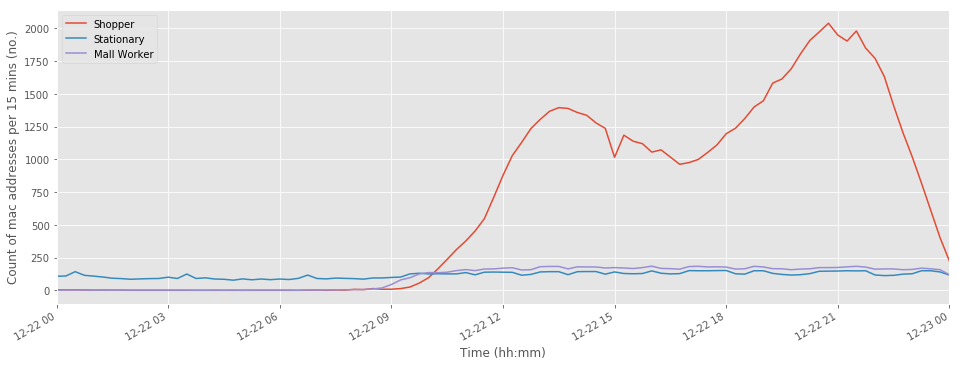

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

macs = mac_address_classified_df[mac_address_classified_df.device == 'Shopper'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Shopper',
);

macs = mac_address_classified_df[mac_address_classified_df.device == 'Stationary'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Stationary',
);

macs = mac_address_classified_df[mac_address_classified_df.device == 'Mall Worker'].mac_address.tolist()

plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(macs)], 
    axes=ax,
    label='Mall Worker',
);

The graphs above shows the number of devices that were seen in the mall over 15 minute intervals. The number of *Stationary devices* stays constant which is expected. The number of *Mall Workers* increases before the opening hours then stays constant until close. The number of *Shoppers* increases after the shops are open; there are two peaks around 13:30 and 21:00 **which are known to be the most busy times for the mall around Christmas (please check this)**.

## Distribution of points for stationary and mall workers (confirmation of difference)

Two plots are shown below for the stationary devices e.g. an ipad computer that has wifi in the store and mall workesr. The plots are scatters distributions of all the devices where the colour depict the denisty of the points. The yellow regions have a higher density of points and, therefore, are more likely to be where the device is located. The blue points are low density regions and are more likely to be the noice of the device.

### Distribution of stationary devices

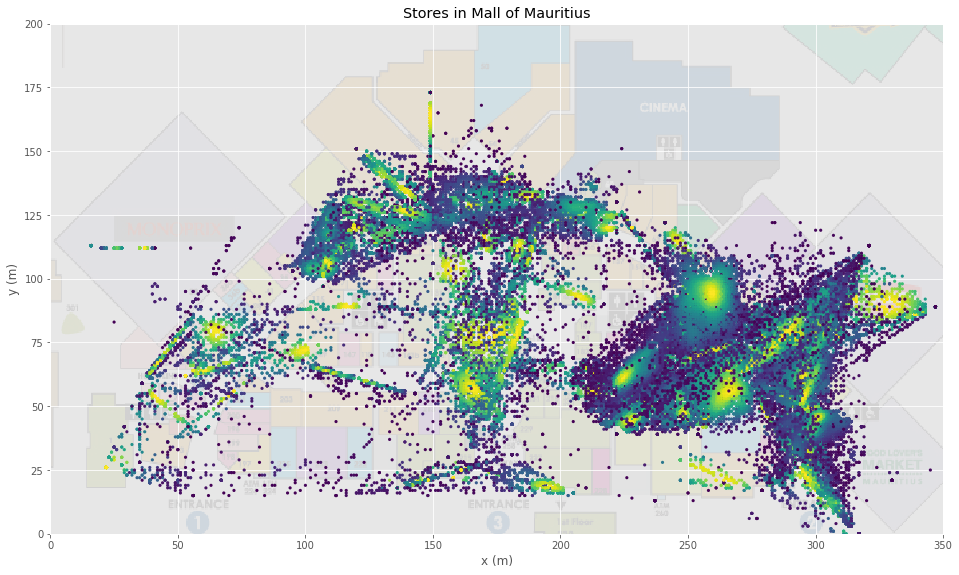

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    mac_address_classified_df[mac_address_classified_df.device == 'Stationary'].mac_address.tolist(),
    axes=ax, 
    plot_type='density', 
    label=False
)

The map above shows a heat map of the distribution of stationary devices clustered via DBSCAN. Signals picked up from these devices are tend to have a directional uncertainty. This can be seen via the yellow regions being distributed along an axis. The right had side of the mall has a far greater uncertainty than the left due to there being more blue points.

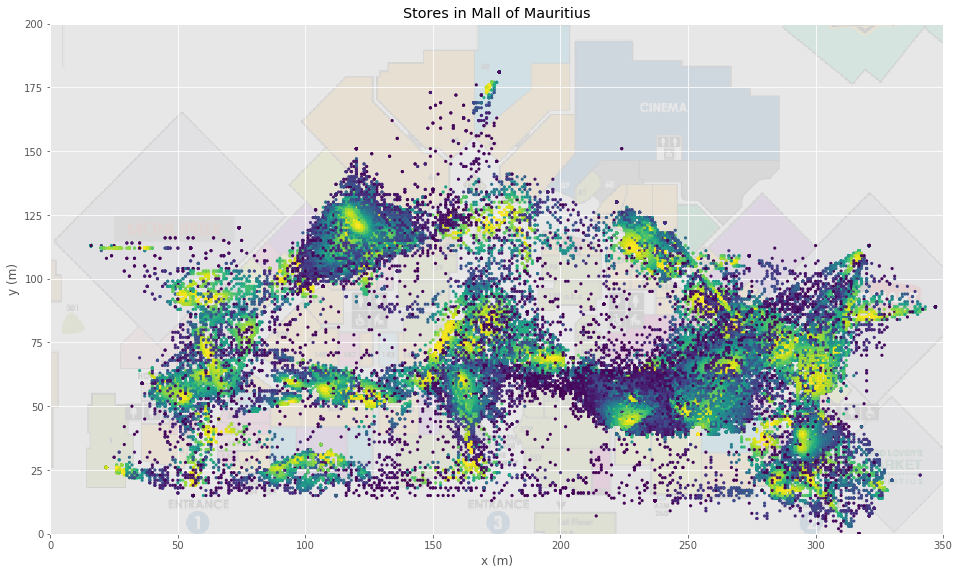

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    mac_address_classified_df[
        (mac_address_classified_df.device == 'Mall Worker')
    ].mac_address.tolist(),
    axes=ax, 
    plot_type='density', 
    label=False
)

The mall staff seem to have reasonably isotropic distributions of points. The dense regions are spread evenly among the store which is expected due to mall staff being in every sttore. Again, there seems to be a greater uncertainty in the distribution around the right hand side of the graph.

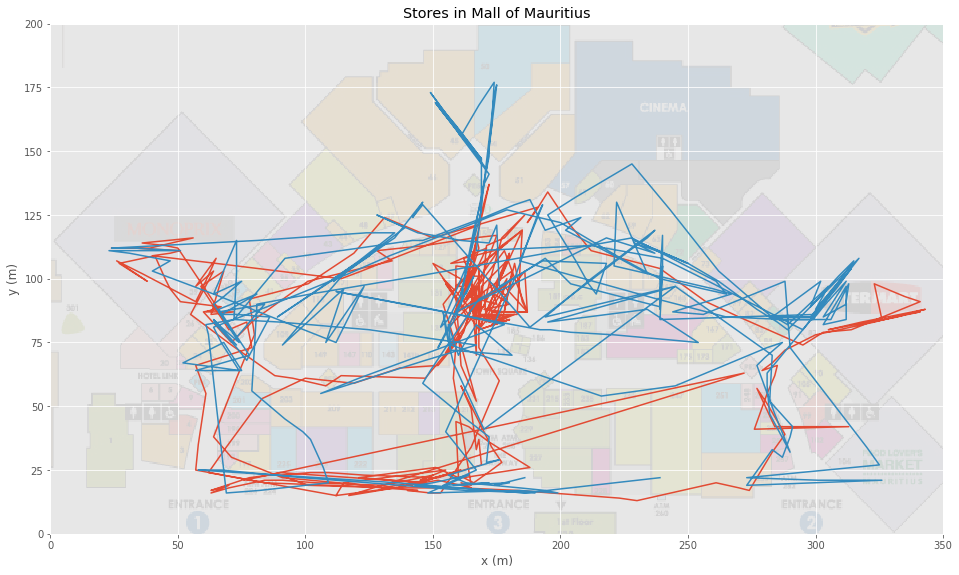

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    mac_address_classified_df[mac_address_classified_df.device == 'Shopper'].mac_address.tolist()[5:7],
    axes=ax, 
    plot_type='', 
    label=False
)

The map of the mall with two shoppers paths shown on them. The paths shown are clearly shoppers moving around the store.